In [1]:
import pandas as pd
import spacy
import scispacy
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import numpy as np


c:\Users\patto\Anaconda3\envs\AIinHealthcare\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import Data

Load the NOTEVENTS, DIAGNOSES_ICD, and D_ICD_DIAGNOSES CSV files.

In [2]:
noteevents_df = pd.read_csv('./NOTEEVENTS.csv')
diagnoses_df = pd.read_csv('./DIAGNOSES_ICD.csv')
ICD9_df = pd.read_csv('./D_ICD_DIAGNOSES.csv')

C:\Users\patto\AppData\Local\Temp\ipykernel_5760\2969941984.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  noteevents_df = pd.read_csv('./NOTEEVENTS.csv')


### Clean Data & Extract Discharge Summaries pertaining to Sepsis ICD-9 code

Filter out non-discharge summaries from NOTEVENTS.

In [3]:
# Define a list of ICD9 codes to filter
icd_codes = ['99592']  # ICD Code for Severe Sepsis

# Filter to only include discharge summaries and select the relevant columns
filtered_notes = noteevents_df[noteevents_df['CATEGORY'] == 'Discharge summary'][['SUBJECT_ID', 'HADM_ID', 'TEXT']]
filtered_notes = filtered_notes.dropna()
#filter down to onnly the ICD9 codes we are interested in
filtered_diagnoses = diagnoses_df[diagnoses_df['ICD9_CODE'] == icd_codes[0]][['HADM_ID', 'ICD9_CODE']]
#print how many rows are in filtered diagnoses
print(filtered_diagnoses.shape[0])

3912


### Merge with Diagnoses Table

Merge the discharge summaries with the diagnoses data on `HADM_ID` 

In [4]:
# Merge the notes with diagnoses on HADM_ID
merged_df = filtered_notes.merge(filtered_diagnoses, on='HADM_ID', how='inner')
#remove duplicated rows
merged_df = merged_df.drop_duplicates(subset='HADM_ID')
print('Number of filtered records:', merged_df.shape[0])
print(merged_df.head())


Number of filtered records: 3792
   SUBJECT_ID   HADM_ID                                               TEXT  \
0       26601  155131.0  Admission Date:  [**2131-12-23**]             ...   
1       27051  113012.0  Admission Date:  [**2194-1-7**]              D...   
2       75347  152030.0  Admission Date:  [**2174-5-3**]              D...   
3       23224  117806.0  Admission Date:  [**2154-4-30**]              ...   
4       19051  184534.0  Admission Date:  [**2172-3-26**]              ...   

  ICD9_CODE  
0     99592  
1     99592  
2     99592  
3     99592  
4     99592  


### Entity Extraction with ClinicalBERT
Use ClinicalBERT’s standard model to extract entities from the note text.

In [ ]:
# Load ClinicalBERT tokenizer & model
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = AutoModelForTokenClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
nlp_bert = pipeline('ner', model=model, tokenizer=tokenizer)

def chunk_text(text, tokenizer, max_length=500, overlap=50):
    """Splits text into overlapping chunks using ClinicalBERT's tokenizer."""
    tokens = tokenizer.encode(text, add_special_tokens=False)  # Convert text to token IDs
    chunks = []
    i = 0
    while i < len(tokens):
        chunk = tokens[i : i + max_length]  # Extract a chunk of tokens
        chunks.append(tokenizer.decode(chunk))  # Convert back to text
        i += max_length - overlap  # Move forward with overlap
    return chunks

def process_text(text):
    """Processes text in chunks for ClinicalBERT."""
    chunks = chunk_text(text, tokenizer)  # Use ClinicalBERT tokenizer to chunk text
    entities = set()
    
    for chunk in chunks:
        results = nlp_bert(chunk)  # Run ClinicalBERT NER on chunk
        for ent in results:  # `results` is a LIST of dictionaries
            entities.add(ent['word'])  # Extract named entity correctly

    return list(entities)  # Return list format for compatibility

# Apply to DataFrame
merged_df['BERT_entities'] = merged_df['TEXT'].apply(process_text)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [6]:
#store new filtered dataframe in csv
merged_df.to_csv('BERTfiltered_sep_df.csv', index=False)

In [ ]:
merged_df = pd.read_csv('BERTfiltered_sep_df.csv')

### Word2Vec Embeddings for ClinicalBERT Entities

Train a Word2Vec model using the ClinicalBERT-extracted entities and compute embeddings.

In [ ]:
sep_corpus = []
for row in range(0, len(merged_df)):
    ent_str = []
    #combine all the entities into one string
    string = ' '.join(merged_df.iloc[row]['BERT_entities'])
    chunks = chunk_text(string, tokenizer)
    for chunk in chunks:
        results = nlp_bert(chunk)
        for ent in results:
            ent_str.append(ent['word'])
    sep_corpus.append(ent_str)

#flatten corpus
flat_corpus = [word for sublist in sep_corpus for word in sublist]

# Train Word2Vec on the Spacy entities
model_BERT = Word2Vec(sep_corpus, min_count=40, vector_size=200, window=10, workers=4)

#print(merged_df[['HADM_ID', 'spacy_embeddings']].head())

### t-SNE Visualization for ClinicalBERT Embeddings

Flatten the embeddings and use t-SNE to visualize them.

In [8]:
def tsne_plot(model,words, preTrained=False):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in words:
      if preTrained:
          tokens.append(model[word])
      else:
          tokens.append(model.wv[word])
      labels.append(word)

    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [9]:
import random
def random_words(corpus, num_words):
    return random.sample(corpus, num_words)

(4258,)


c:\Users\patto\Anaconda3\envs\AIinHealthcare\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


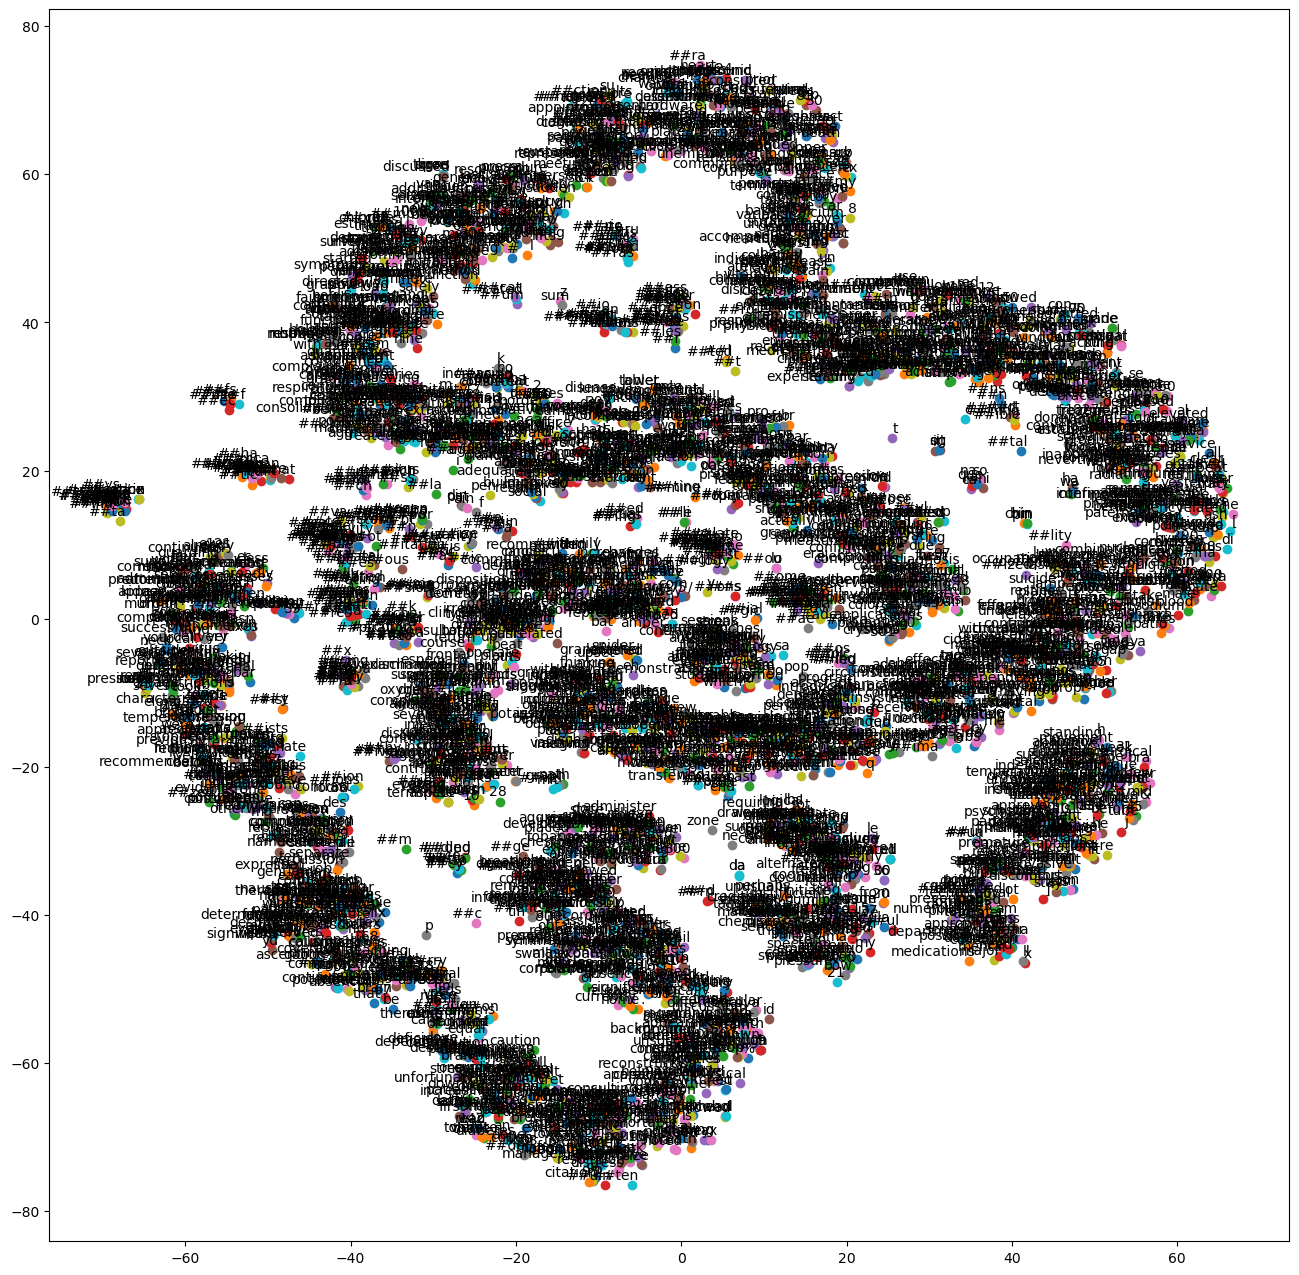

In [12]:
vocabs = model_BERT.wv.key_to_index.keys()
#new_v = np.array(random_words(list(vocabs), 1000))
new_v = np.array(list(vocabs))
print(new_v.shape)
tsne_plot(model_BERT,new_v)

In [23]:
vocabs = model_BERT.wv.most_similar('5', topn=10)
vocabs

[('demonstrated', 0.4678769111633301),
 ('contraction', 0.4512701630592346),
 ('assist', 0.4420042634010315),
 ('even', 0.4361738860607147),
 ('limited', 0.4296383261680603),
 ('slight', 0.41502293944358826),
 ('niece', 0.41350623965263367),
 ('flow', 0.4103519320487976),
 ('felt', 0.4067225754261017),
 ('cigarette', 0.40277040004730225)]